<a href="https://colab.research.google.com/github/gabibu/aiforhealthcare/blob/main/advanced_models_colab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 7.9 MB/s 


In [2]:
from torch.utils.data import Dataset, WeightedRandomSampler
from skimage import io, transform
import os
import pandas as pd
from PIL import Image
import random
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from imageio import imread
import torch
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import cm

import pydicom
from abc import ABC, abstractmethod
from torchvision.transforms import RandomHorizontalFlip, RandomVerticalFlip, RandomRotation
from sklearn.model_selection import train_test_split
import cv2
import albumentations as A

In [3]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)


In [4]:
print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))
device = 'cuda' if torch.cuda.is_available() else 'cpu'

DATA_FOLDER ='data'
device

__pyTorch VERSION: 1.11.0+cu113
use_cuda = True


'cuda'

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!ls "/content/drive/My Drive/medical"


aug.weights		      weighted_2.weights
baseline.weights	      weighted_sampling.weights
dicom-images-train.zip	      with_augmentations_and_weighted_loss.weights
simple_preprocessing.weights  with_augmentations.weights
train-rle.csv


In [8]:
!cp "/content/drive/My Drive/medical/dicom-images-train.zip" "dicom-images-train.zip"


In [9]:
!cp '/content/drive/My Drive/medical/train-rle.csv' "train-rle.csv"


In [10]:
!ls

dicom-images-train.zip	drive  sample_data  train-rle.csv


In [11]:
!unzip  -q dicom-images-train.zip -d data 


In [12]:
SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)
SEED

999

In [13]:
! ls data

dicom-images-train


In [14]:
train_imgs_paths = sorted(glob.glob('data/dicom-images-train/*/*/*.dcm'))
print("Train images size {}".format(len(train_imgs_paths)))

# test_imgs_paths = sorted(glob('../input/siim-acr-pneumothorax-segmentation-data/dicom-images-test/*/*/*.dcm'))
# print("Test images -", len(test_imgs_paths))
# file_paths = train_imgs_paths + test_imgs_paths

Train images size 10712


In [15]:

rles_df = pd.read_csv('train-rle.csv')
rles_df = rles_df.rename(columns={' EncodedPixels':'EncodedPixels'})
rles_df['EncodedPixels'] = rles_df['EncodedPixels'].apply(lambda x: x.strip())

# Create a dictionary for images with masks
rles_df = rles_df[rles_df['EncodedPixels'] !='-1'].groupby('ImageId')['EncodedPixels'].apply(list).reset_index()
print(len(rles_df))

masks = {}
for index, row in rles_df.iterrows():
    masks[row['ImageId']] = row['EncodedPixels']
print(len(masks))

2379
2379


In [16]:
dataset_rows = []
for image_path in train_imgs_paths:
  id = image_path.split('/')[-1][:-4]
  
  mask = masks[id] if id in masks else None
  dataset_rows.append((id, mask, image_path))

dataset_df = pd.DataFrame(dataset_rows, columns = ['image_id', 'rle', 'image_path'])
dataset_df.sample(3)


,image_id,rle,image_path
9104,1.2.276.0.7230010.3.1.4.8323329.4329.151787518...,[191086 2 1017 8 1012 12 1009 14 1008 15 1007 ...,data/dicom-images-train/1.2.276.0.7230010.3.1....
1436,1.2.276.0.7230010.3.1.4.8323329.11314.15178752...,[338146 2 1020 3 1019 5 1017 7 1016 7 1015 8 1...,data/dicom-images-train/1.2.276.0.7230010.3.1....
10277,1.2.276.0.7230010.3.1.4.8323329.540.1517875163...,None,data/dicom-images-train/1.2.276.0.7230010.3.1....


In [17]:
X_train_df, X_val_df = train_test_split(dataset_df, test_size=0.1, random_state=SEED)
X_train_df.shape, X_val_df.shape

((9640, 3), (1072, 3))

In [18]:
class ImagesDataset(Dataset):
    def __init__(self, df, image_size = 128, transform = None):
        self.df = df
        self.transform = transform
        self.image_size = image_size
        
      
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        
        row = self.df.iloc[index]

        X = np.zeros((self.image_size, self.image_size))
        y = np.zeros((self.image_size, self.image_size))

        image_path = row['image_path']

        image = pydicom.read_file(image_path).pixel_array
        image_resized = cv2.resize(image, (self.image_size, self.image_size))
        image_resized = np.array(image_resized, dtype=np.float64)

        

        mask = np.zeros((1024, 1024))

        rle = row['rle']
        if rle is not None:
          for r in rle:
            mask =  mask + rle2mask(r, 1024, 1024).T

        mask_resized = cv2.resize(mask, (self.image_size, self.image_size))

        mask_resized = np.where(mask_resized  > 0, 1, 0)

        if self.transform is not None:
          
          transformed = self.transform(image=image_resized, mask=mask_resized)
          image_resized = transformed['image']
          mask_resized = transformed['mask']
          
        return np.expand_dims(image_resized/255.0, 0), np.expand_dims(mask_resized, 0)



In [19]:
transformations = A.Compose(
    transforms=[
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=30)
        ],
    additional_targets={'image0': 'image', 'image1': 'mask'}
)


In [20]:
train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)

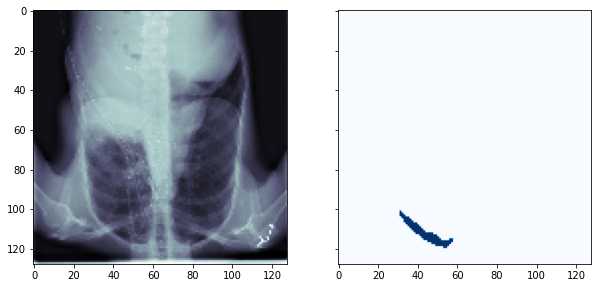

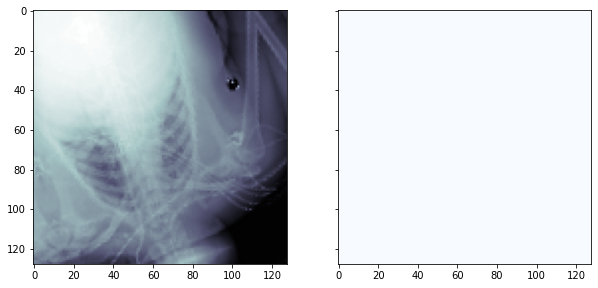

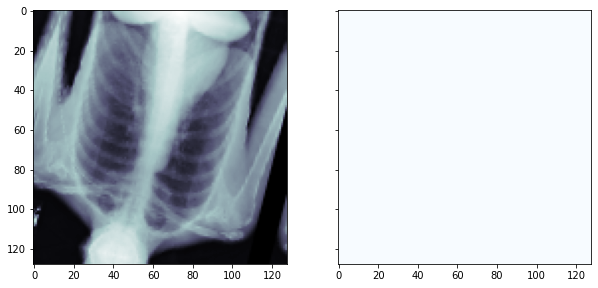

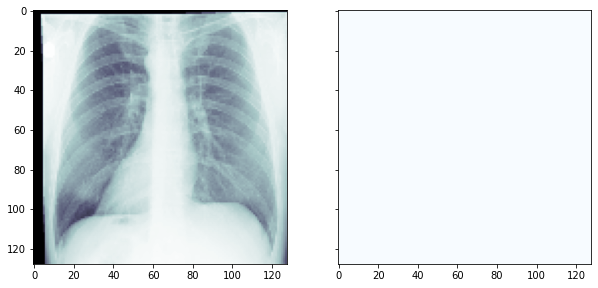

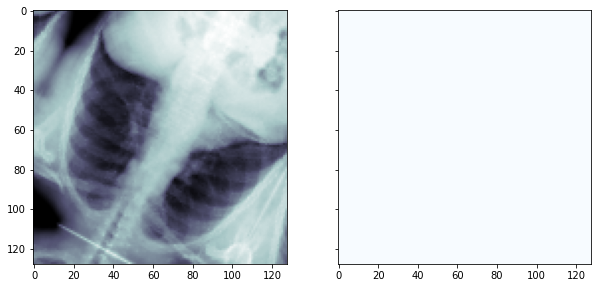

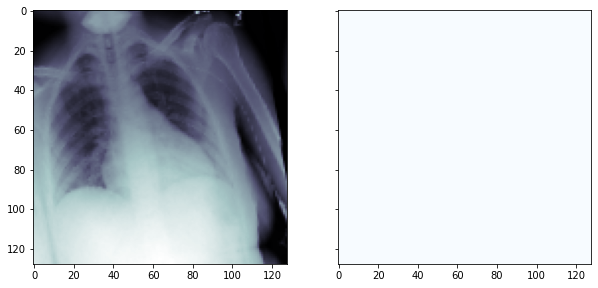

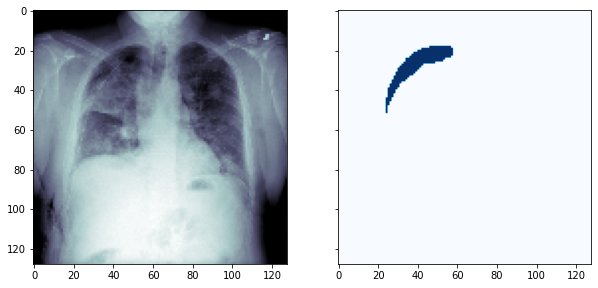

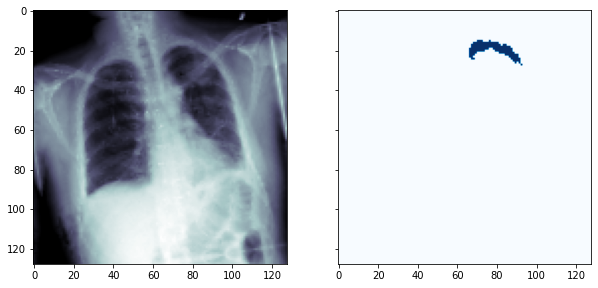

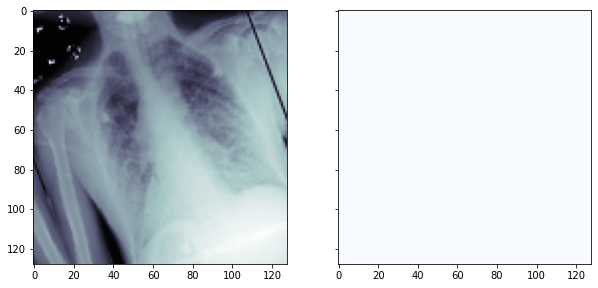

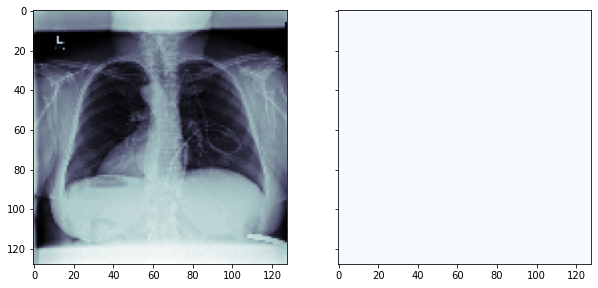

In [21]:
for i in np.random.choice(len(train_dataset), size =10, replace = False):
    x, y = train_dataset.__getitem__(i)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)
    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')
 

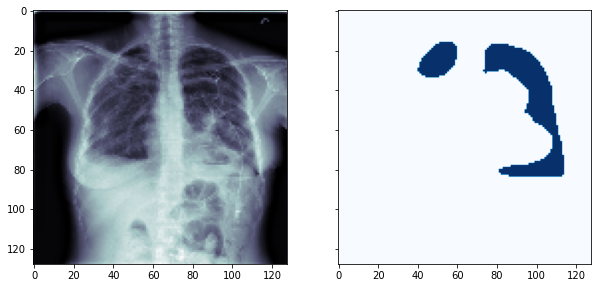

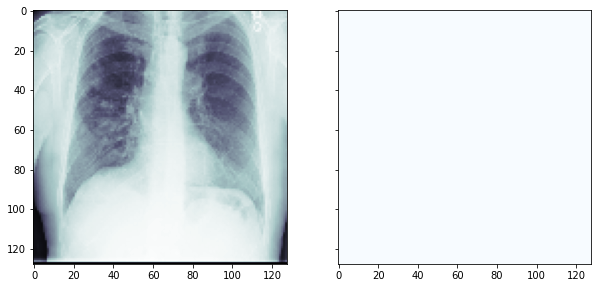

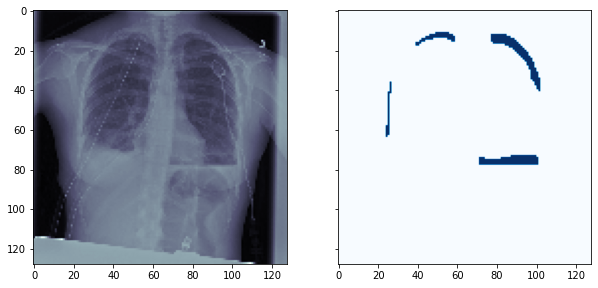

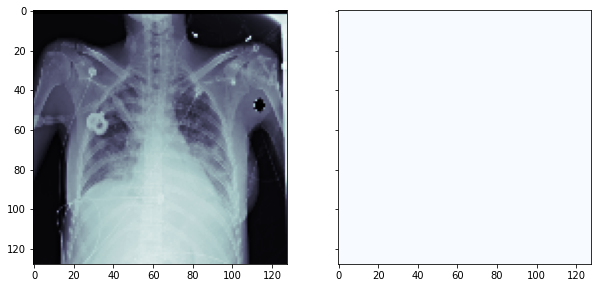

In [22]:

for i in np.random.choice(len(validation_dataset), size =4, replace = False):    
    x, y = validation_dataset.__getitem__(i)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)

    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')

Transformations for the same image

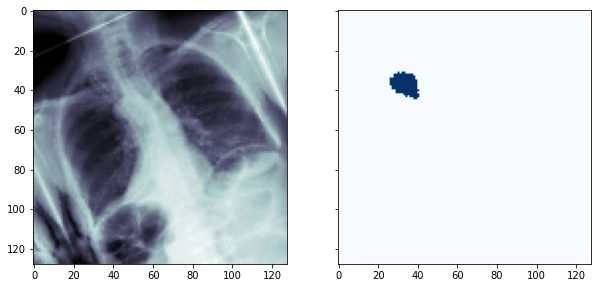

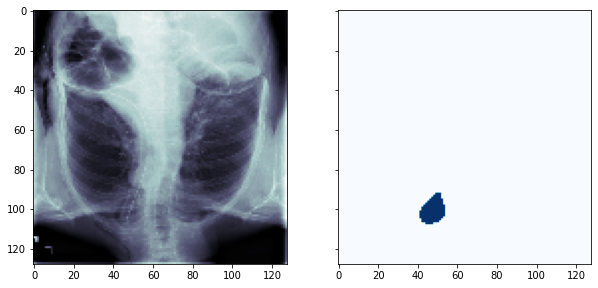

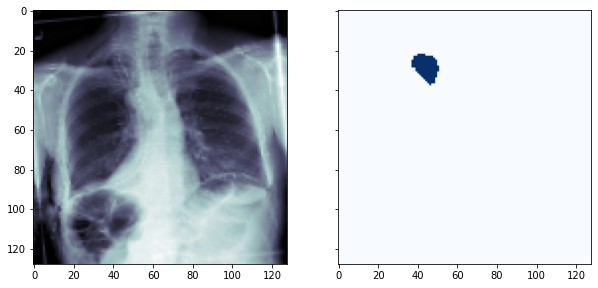

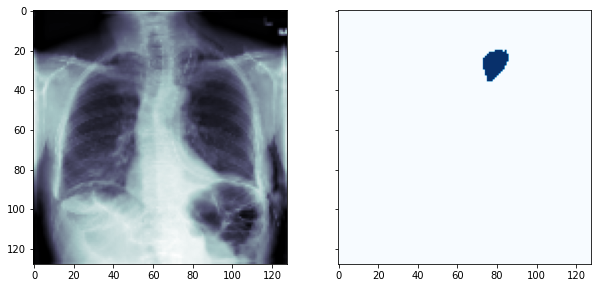

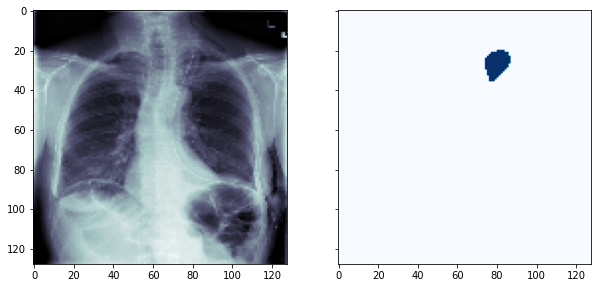

In [23]:
positive_dataset = ImagesDataset(X_train_df[X_train_df['rle'].notnull()], transform = transformations)

image_index = np.random.choice(len(positive_dataset), size =1, replace = False)[0]

for i in range(5):    
    x, y = positive_dataset.__getitem__(image_index)
    x = np.squeeze(x, 0)
    y = np.squeeze(y, 0)

    n=1
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
    ax[0].imshow(x,cmap='bone')
    ax[1].imshow(y,cmap='Blues')


UNET

In [24]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 128)
        self.down1 = Down(128, 256)
        self.down2 = Down(256, 512)
        self.down3 = Down(512, 1024)
        factor = 2 if bilinear else 1
        self.down4 = Down(1024, 2048 // factor)
        
        self.up1 = Up(2048, 1024 // factor, bilinear)
        self.up2 = Up(1024, 512 // factor, bilinear)
        self.up3 = Up(512, 256 // factor, bilinear)
        self.up4 = Up(256, 128, bilinear)
        self.outc = OutConv(128, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

losses 

In [25]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [26]:
def train(model, data_loader, optimizer, criterion):
    calc_loss = 0.
    calc_count = 0.

    model.train()

    for images, labels in data_loader:

        calc_count += labels.shape[0]
        images = images.float().to(device)
     
        labels = labels.float().to(device)
        images = Variable(images)
        labels = Variable(labels)

        output = model(images)
        loss = criterion(output, labels)
        calc_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return calc_loss/calc_count


def eval_model(model, data_loader, criterion):
    model.eval()
    
    calc_loss = 0.
    calc_count = 0.
    
    with torch.no_grad():
        for images, labels in data_loader:
            calc_count += labels.shape[0]
            images = images.float().to(device)

            labels = labels.float().to(device)
            images = Variable(images)
            labels = Variable(labels)
            output = model(images)
            loss = criterion(output, labels)
            calc_loss += loss.item()
            
        
    return calc_loss/calc_count

    

In [27]:
def run_experiment(exp_name, model, criterion, optimizer, numer_of_epoch, train_data_loader, validation_data_loader):
    
    min_val_loss = 100000
    weights_path = '/content/drive/My Drive/medical/{}.weights'.format(exp_name)

    for epoch in range(numer_of_epoch):
        print(epoch)
        train_loss = train(model, train_data_loader, optimizer, criterion)
        val_loss = eval_model(model, validation_data_loader, criterion)

        if val_loss < min_val_loss:
          min_val_loss =  val_loss

         
          torch.save(model.state_dict(), weights_path)

        print('epoch {} train loss {} val loss {}'.format(epoch, train_loss, val_loss))

In [107]:
train_dataset = ImagesDataset(X_train_df, transform = None)

num_of_positive_pixels = 0 
num_of_negative_pixels = 0 
for _, y in train_dataset:
  current_num_of_positive_pixels = np.sum(y) 
  num_of_positive_pixels += current_num_of_positive_pixels
  num_of_negative_pixels += y.size - current_num_of_positive_pixels


pos_weight = num_of_negative_pixels/num_of_positive_pixels 
pos_weight


318.0098161987477

Baseline

In [103]:
#baseline
model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 100
momentum = 0.9


criterion =nn.BCEWithLogitsLoss().to(device) 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


train_dataset = ImagesDataset(X_train_df, transform = None)

validation_dataset = ImagesDataset(X_val_df)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

run_experiment('baseline', model, criterion, optimizer, num_epochs, train_data_loader, validation_data_loader)


In [ ]:
#pixel accuracy
#Intersection-Over-Union (area of overlap)/area of uion
# Dice Coefficient is 2 * the Area of Overlap divided by the total number of pixels in both images



In [104]:
#with_augmentations
model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 10
momentum = 0.9

criterion =nn.BCEWithLogitsLoss().to(device) 
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

run_experiment('with_augmentations', model, criterion, optimizer, num_epochs, train_data_loader, validation_data_loader)


0
epoch 0 train loss 0.009749504855806897 val loss 0.004379940000293192
1
epoch 1 train loss 0.002918760224218438 val loss 0.002094794824066113
2
epoch 2 train loss 0.001750500630819204 val loss 0.0015662429722220596
3
epoch 3 train loss 0.0013777858753016227 val loss 0.0013044369780569713
4
epoch 4 train loss 0.0012222538188706572 val loss 0.0011506628378906024
5
epoch 5 train loss 0.0011442825935309544 val loss 0.001077156763266661
6
epoch 6 train loss 0.0010889509316974347 val loss 0.0010482359689715972
7
epoch 7 train loss 0.0010457906240927775 val loss 0.000983191846736095
8
epoch 8 train loss 0.001017222795258682 val loss 0.0009925051778207409
9
epoch 9 train loss 0.0009860816722517423 val loss 0.0009600532789794562


In [108]:

#weighted loss 
print('pos_weight {}'.format(pos_weight))


model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 10

pos_weight_tensor = torch.as_tensor(pos_weight, dtype=torch.float).to(device)
criterion =nn.BCEWithLogitsLoss(pos_weight = pos_weight_tensor).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dataset = ImagesDataset(X_train_df, transform = None)

validation_dataset = ImagesDataset(X_val_df)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

run_experiment('with_weighted_loss', model, criterion, optimizer, num_epochs, train_data_loader, validation_data_loader)


pos_weight 318.0098161987477
0
epoch 0 train loss 0.057623852025794786 val loss 0.04983582125226064
1
epoch 1 train loss 0.04769222943490966 val loss 0.04392319795355868
2
epoch 2 train loss 0.04253811975979706 val loss 0.04236640547638509
3
epoch 3 train loss 0.038255277319320505 val loss 0.03824128049300678
4
epoch 4 train loss 0.035675472741428745 val loss 0.041389494828546224
5
epoch 5 train loss 0.03200495548669975 val loss 0.03566301555664682
6
epoch 6 train loss 0.030554391333980184 val loss 0.029732284914535372
7
epoch 7 train loss 0.027105109407508522 val loss 0.033248184804818524
8
epoch 8 train loss 0.025618271099952246 val loss 0.03105941209108082
9
epoch 9 train loss 0.024075100796598616 val loss 0.028747697986328778


In [111]:

#with_augmentations and weighted loss 

print('pos_weight {}'.format(pos_weight))

model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 10
momentum = 0.9

pos_weight_tensor = torch.as_tensor(pos_weight, dtype=torch.float).to(device)
criterion =nn.BCEWithLogitsLoss(pos_weight = pos_weight_tensor).to(device) 
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

run_experiment('with_augmentations_and_weighted_loss', model, criterion, optimizer, num_epochs, train_data_loader, validation_data_loader)


pos_weight 318.0098161987477
0
epoch 0 train loss 0.06494809142410508 val loss 0.05492412393440062
1
epoch 1 train loss 0.05730289722255651 val loss 0.053806390307510076
2
epoch 2 train loss 0.05549437162230618 val loss 0.04864163913611156
3
epoch 3 train loss 0.04911736714271094 val loss 0.04761580277734728
4
epoch 4 train loss 0.04701486806466372 val loss 0.04218068257419031
5
epoch 5 train loss 0.04360684680122558 val loss 0.05057426658806516
6
epoch 6 train loss 0.04191682986080399 val loss 0.0387882043732636
7
epoch 7 train loss 0.04441721940807287 val loss 0.039180696260795664
8
epoch 8 train loss 0.04026477645727114 val loss 0.03689370932641314
9
epoch 9 train loss 0.0383047064248457 val loss 0.038418723548303786


In [112]:
num_of_positive_slices = X_train_df[X_train_df['rle'].notnull()].shape[0]

total_slices = float(X_train_df.shape[0])
num_of_negative_slices = X_train_df.shape[0] - num_of_positive_slices

sampling_weights = X_train_df.apply(lambda r: 1.0/num_of_positive_slices if r['rle'] is not None else 1.0/num_of_negative_slices, axis=1).tolist()

sampling_weights[0:4]

[0.00013326226012793177,
 0.00046816479400749064,
 0.00046816479400749064,
 0.00013326226012793177]

In [ ]:
#weighted smapling of positive and negative slices 

model = UNet(1, 1, False).to(device)
lr = 0.0001
batch_size = 16
num_epochs = 10
momentum = 0.9
number_of_epocs = 10

criterion =nn.BCEWithLogitsLoss().to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_dataset = ImagesDataset(X_train_df, transform = transformations)

validation_dataset = ImagesDataset(X_val_df)


train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, sampler = WeightedRandomSampler(sampling_weights, len(sampling_weights), replacement=True))
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    

run_experiment('weighted_sampling_and_augmentations',model, criterion, optimizer, number_of_epocs, train_data_loader, validation_data_loader)

0


In [124]:
# train_data_loader = DataLoader(train_dataset, num_workers=0, batch_sampler = WeightedRandomSampler(sampling_weights, batch_size, replacement=False))
# x1 = 0
# for (x,y) in train_data_loader:
#   x1 += 1

# x1

wr = WeightedRandomSampler(sampling_weights, len(sampling_weights), replacement=True)

from collections import defaultdict

cc = defaultdict(lambda : 0)
for x in wr:
  cc[x] += 1


cc = [(x,y) for (x,y) in cc.items()]
sorted(cc, key = lambda u: u[1], reverse = True)[0:5]

[(654, 9), (9291, 8), (2291, 8), (829, 7), (2817, 7)]

EVAL

In [75]:
#def eval_model(exp_name, data_loader):

exp_name = 'baseline'
weights_path = '/content/drive/My Drive/medical/{}.weights'.format(exp_name)
model = UNet(1, 1, False).to(device)
model.load_state_dict(torch.load(weights_path))

model.eval()
validation_dataset = ImagesDataset(X_val_df[X_val_df['rle'].notnull()])
data_loader = DataLoader(validation_dataset, batch_size=8, shuffle=True, num_workers=0)

with torch.no_grad():

  for images, labels in data_loader:
    images = images.float().to(device)

    #labels = labels.float().to(device)

    images = Variable(images)
    #labels = Variable(labels)
    output = model(images)
    output = torch.sigmoid(output)
    output = output.detach().cpu().numpy()
    labels = labels.numpy()
    break





In [86]:
y = np.where(output > 0.3, 1, 0)
np.sum(y == labels)/labels.size, np.sum(labels), np.sum(y)


(0.9746170043945312, 3486, 1419)

In [101]:
output1 = output[0]
labels1 = labels[0]

y1 = np.where(output1 > 0.1, 1, 0)

y22 = y1 + labels1
y22 = np.where(y22 == 2, 1, 0)

np.sum(y1 == labels1)/labels1.size, np.sum(labels1), np.sum(y1), np.sum(y22)

(0.97119140625, 214, 646, 194)

In [98]:
output1.shape, labels1.shape

((1, 128, 128), (1, 128, 128))

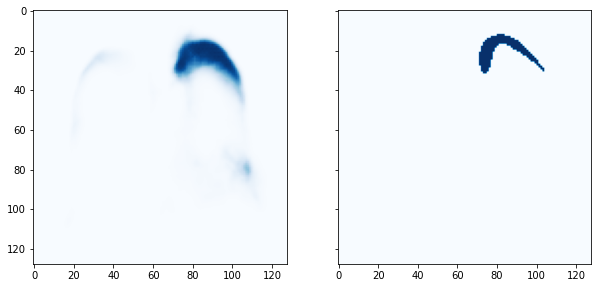

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,7))
     
ax[0].imshow(output1[0],cmap='Blues')
ax[1].imshow(labels1[0],cmap='Blues')